In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import gc
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

SEED = 0

Using TensorFlow backend.


In [2]:
%%time
df_train_identity = pd.read_csv('../input/train_identity.csv')
df_test_identity = pd.read_csv('../input/test_identity.csv')
df_train_transaction = pd.read_csv('../input/train_transaction.csv')
df_test_transaction = pd.read_csv('../input/test_transaction.csv')
df_train_merged = pd.merge(df_train_transaction, df_train_identity, how='left', on='TransactionID')
X_train = df_train_merged.drop('isFraud', axis=1)
y_train = df_train_merged['isFraud'].copy()
X_test = pd.merge(df_test_transaction, df_test_identity, how='left', on='TransactionID')

print('Number of Training Examples = {}'.format(df_train_transaction.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test_transaction.shape[0]))
print('Number of Training Examples with Identity = {}'.format(df_train_identity.shape[0]))
print('Number of Test Examples with Identity = {}\n'.format(df_test_identity.shape[0]))
print('Training X Shape = {}'.format(X_train.shape))
print('Training y Shape = {}'.format(y_train.shape))
print('Test X Shape = {}\n'.format(X_test.shape))

del df_train_identity, df_test_identity, df_train_transaction, df_test_transaction, df_train_merged
gc.collect()

Number of Training Examples = 590540
Number of Test Examples = 506691

Number of Training Examples with Identity = 144233
Number of Test Examples with Identity = 141907

Training X Shape = (590540, 433)
Training y Shape = (590540,)
Test X Shape = (506691, 433)

CPU times: user 48.2 s, sys: 18.1 s, total: 1min 6s
Wall time: 1min 6s


96

In [3]:
'''%%time
vs = ['V258', 'V201', 'V70', 'V91', 'V246', 'V294', 'V189', 'V156']

for df in [X_train, X_test]:
    for vcol in vs:
        df['{}_vc'.format(vcol)] = df.groupby(vcol)[vcol].transform('count')
        df['{}_vc'.format(vcol)] = df['{}_vc'.format(vcol)].fillna(df[vcol].isnull().sum())
        gc.collect()'''
    

"%%time\nvs = ['V258', 'V201', 'V70', 'V91', 'V246', 'V294', 'V189', 'V156']\n\nfor df in [X_train, X_test]:\n    for vcol in vs:\n        df['{}_vc'.format(vcol)] = df.groupby(vcol)[vcol].transform('count')\n        df['{}_vc'.format(vcol)] = df['{}_vc'.format(vcol)].fillna(df[vcol].isnull().sum())\n        gc.collect()"

In [4]:
'''X_train['isFraud'] = y_train
device_fingerprint = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33', 'isFraud']
device_test = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33']
X_train[X_train['DeviceInfo'] == 'Trident/7.0'][device_fingerprint]'''

"X_train['isFraud'] = y_train\ndevice_fingerprint = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33', 'isFraud']\ndevice_test = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33']\nX_train[X_train['DeviceInfo'] == 'Trident/7.0'][device_fingerprint]"

In [5]:
'''X_train['isFraud'] = y_train

cards = ['card{}'.format(i) for i in range(1, 7)]
ids = ['id_{}'.format(i) for i in range(12, 39)]
cat_features = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo'] + cards + ids + ['isFraud']

X_train[X_train['isFraud'] == 1][cat_features]'''

"X_train['isFraud'] = y_train\n\ncards = ['card{}'.format(i) for i in range(1, 7)]\nids = ['id_{}'.format(i) for i in range(12, 39)]\ncat_features = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo'] + cards + ids + ['isFraud']\n\nX_train[X_train['isFraud'] == 1][cat_features]"

In [6]:
'''device_info_map = {'Trident/7.0': 'Windows', 'rv:11.0': 'Windows',  'rv:57.0': 'Windows', 'rv:58.0': 'Windows', 'rv:52.0': 'Windows',
                   'rv:59.0': 'Windows', 'rv:48.0': 'MacOS', 'rv:56.0': 'Windows'}

X_train[X_train['DeviceInfo'].str.startswith('rv', na=False)]['DeviceInfo'].value_counts()'''

"device_info_map = {'Trident/7.0': 'Windows', 'rv:11.0': 'Windows',  'rv:57.0': 'Windows', 'rv:58.0': 'Windows', 'rv:52.0': 'Windows',\n                   'rv:59.0': 'Windows', 'rv:48.0': 'MacOS', 'rv:56.0': 'Windows'}\n\nX_train[X_train['DeviceInfo'].str.startswith('rv', na=False)]['DeviceInfo'].value_counts()"

In [7]:
'''for df in [X_train, X_test]:    
    df['domain_name'] = df['P_emaildomain'].str.split('.', expand=True)[0]
    df['pixels'] = df['id_33'].str.split('x', expand=True)[0].astype(float) * df['id_33'].str.split('x', expand=True)[1].astype(float)
    df.drop(columns=['TransactionDT'], inplace=True)
'''
for feature in X_train.columns:
    if X_train[feature].dtype == 'object' or X_test[feature].dtype == 'object': 
        lbl = LabelEncoder()
        lbl.fit(list(X_train[feature].values) + list(X_test[feature].values))
        X_train[feature] = lbl.transform(list(X_train[feature].values))
        X_test[feature] = lbl.transform(list(X_test[feature].values))


In [8]:
'''sparse = []

for df in [X_train, X_test]:
    for feature in df.columns:
        counts = df[feature].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            sparse.append(feature)
            
sparse = list(set(sparse))
sparse'''

'sparse = []\n\nfor df in [X_train, X_test]:\n    for feature in df.columns:\n        counts = df[feature].value_counts()\n        zeros = counts.iloc[0]\n        if zeros / len(df) * 100 > 99.9:\n            sparse.append(feature)\n            \nsparse = list(set(sparse))\nsparse'

In [9]:
'''for df in [X_train, X_test]:
    df.drop(columns=sparse, inplace=True)'''

'for df in [X_train, X_test]:\n    df.drop(columns=sparse, inplace=True)'

In [10]:
%%time
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 1955.37 MB
Memory usage after optimization is: 529.39 MB
Decreased by 72.9%
Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 461.96 MB
Decreased by 72.5%
CPU times: user 1min 46s, sys: 4min 38s, total: 6min 24s
Wall time: 6min 24s


In [11]:
'''for df in [X_train, X_test]:
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])'''

"for df in [X_train, X_test]:\n    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])"

In [12]:
drop_cols = ['TransactionID', 'TransactionDT']

for df in [X_train, X_test]:
    df.drop(columns=drop_cols, inplace=True)

In [13]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    tree_method='gpu_hist'
)

gc.collect()

14

In [14]:
def downsample(X, y):   
    X['isFraud'] = y
    m = X['isFraud'] == 1
    
    fraud, not_fraud = X[m].copy(), X[~m].copy()
    downsampled = resample(not_fraud, replace=False, n_samples=(len(fraud) * 2), random_state=SEED)

    Xn = pd.concat([downsampled, fraud])
    yn = Xn['isFraud'].copy()
    Xn = Xn.drop(columns=['isFraud'])

    return Xn, yn

In [15]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

sm = SMOTE(ratio=0.2, random_state=SEED)

In [16]:
N = 10
skf = StratifiedKFold(n_splits=N, shuffle=True, random_state=SEED)

importance = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=X_train.columns)
score = 0
y_pred = np.zeros(X_test.shape[0])
oof = np.zeros(X_train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}'.format(fold))
      
    X_tr, X_vl = X_train.iloc[trn_idx, :].values, X_train.iloc[val_idx, :].values
    y_tr, y_vl = y_train.iloc[trn_idx].values, y_train.iloc[val_idx].values
    
    print('X shape before: {}'.format(X_tr.shape))    
    X_res, y_res = sm.fit_sample(X_tr, y_tr)
    print('X shape after: {}'.format(X_res.shape))
    
    del X_tr, y_tr 
    gc.collect()
    
    clf.fit(X_res, y_res)
    
    predictions = clf.predict_proba(X_vl)[:, 1]
    importance.iloc[:, fold - 1] = clf.feature_importances_
    oof[val_idx] = predictions
    
    score += roc_auc_score(y_vl, predictions) / N
    print('Fold {} ROC AUC Score {}\n'.format(fold, roc_auc_score(y_vl, predictions)))
    
    y_pred += clf.predict_proba(X_test.values)[:, 1] / N
    
    del X_vl, y_vl, X_res, y_res, predictions
    gc.collect()
    
print('Average ROC AUC Score {}'.format(score))

Fold 1
X shape before: (531485, 431)
X shape after: (615466, 431)
Fold 1 ROC AUC Score 0.9595600915685183

Fold 2
X shape before: (531485, 431)
X shape after: (615466, 431)
Fold 2 ROC AUC Score 0.9570090236024871

Fold 3
X shape before: (531485, 431)
X shape after: (615466, 431)
Fold 3 ROC AUC Score 0.9606041115981638

Fold 4
X shape before: (531486, 431)
X shape after: (615466, 431)
Fold 4 ROC AUC Score 0.9565281903066701

Fold 5
X shape before: (531486, 431)
X shape after: (615466, 431)
Fold 5 ROC AUC Score 0.9574507788565872

Fold 6
X shape before: (531486, 431)
X shape after: (615466, 431)
Fold 6 ROC AUC Score 0.9550160642504788

Fold 7
X shape before: (531486, 431)
X shape after: (615466, 431)
Fold 7 ROC AUC Score 0.9537017813434137

Fold 8
X shape before: (531487, 431)
X shape after: (615468, 431)
Fold 8 ROC AUC Score 0.9576221388512871

Fold 9
X shape before: (531487, 431)
X shape after: (615468, 431)
Fold 9 ROC AUC Score 0.9589099658961637

Fold 10
X shape before: (531487, 431)

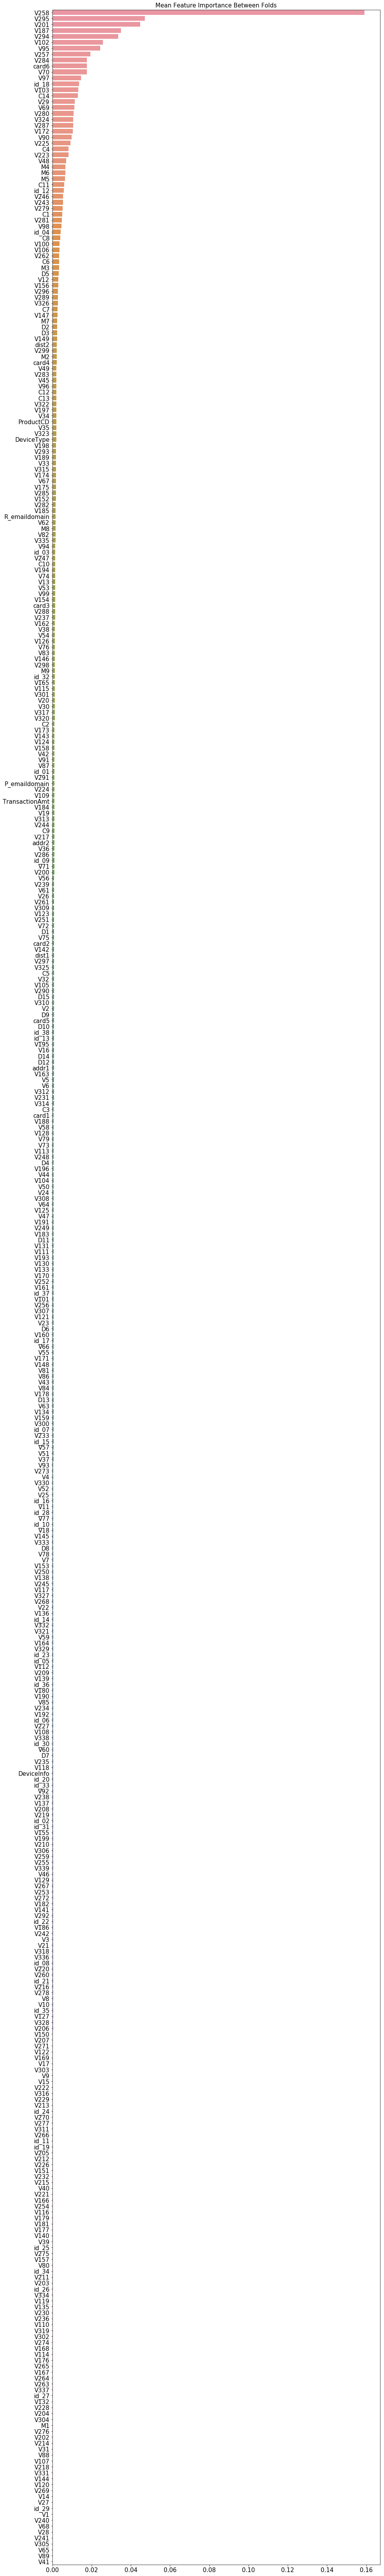

In [17]:
importance['Mean_Importance'] = importance.sum(axis=1) / N
importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 120))
sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Mean Feature Importance Between Folds', size=15)

plt.show()

In [18]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
submission['isFraud'] = y_pred
submission.to_csv('submission.csv')

In [19]:
submission.head()

,isFraud
TransactionID,
3663549,0.003958
3663550,0.002785
3663551,0.003510
3663552,0.002282
3663553,0.002465
